In [1]:
import pandas as pd
import numpy as np

In [2]:
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

import itertools

C:\Users\胡逸凡\AppData\Roaming\Python\Python310\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [3]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [4]:
df = pd.read_csv('day_level_dataset/ccso_2023-06-01_2023-12-31.csv')
df = df.sort_values(['dt','kdcode'])
df = df.fillna(0)
df.rename(columns={'dt':'date', 'kdcode':'tic'}, inplace=True)
df.rename(columns={'Last':'last', 'HighPrice':'high', 'Volume':'volume', 'TurnOver':'turnover', 'OpenPrice':'open', 'LowPrice':'low', }, inplace=True)

In [5]:
df

,date,tic,close,last,volume,turnover,open,high,low,TotalNo,...,BidVol6,Bid7,BidVol7,Bid8,BidVol8,Bid9,BidVol9,Bid10,BidVol10,label
6624,2023-06-01,600000.XSHG,7.275556,7.294183,19.623353,21.611260,7.33,7.347208,7.267917,4.449198,...,15.377164,7.138017,15.199319,7.128142,14.884772,7.118267,14.731421,7.108392,14.358886,0.994064
19008,2023-06-01,600008.XSHG,3.050000,3.063920,20.324832,21.443540,3.08,3.087250,3.040375,4.933034,...,16.838710,2.960492,16.670304,2.950615,16.292827,2.940738,15.983040,2.930861,15.633435,1.023490
22608,2023-06-01,600015.XSHG,5.730000,5.754824,19.498933,21.249332,5.77,5.806542,5.711750,4.427388,...,15.420127,5.618904,15.370532,5.609029,15.119865,5.599154,14.938520,5.589279,14.802823,0.997709
22752,2023-06-01,600017.XSHG,3.010000,3.008880,19.648348,20.747041,2.99,3.032292,2.961583,4.365749,...,16.327169,2.908928,16.151398,2.899053,15.610075,2.889178,15.203544,2.879303,14.887010,0.988867
9360,2023-06-01,600018.XSHG,5.260000,5.285801,18.915014,20.580564,5.28,5.309917,5.269542,4.288460,...,14.963574,5.155424,14.678727,5.145549,14.602763,5.135674,14.417904,5.125799,14.103783,1.004776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15551,2023-12-29,688728.XSHG,20.477000,20.391906,18.222323,21.237417,20.65,20.690000,20.181583,4.068172,...,11.859839,20.063560,12.107815,20.053227,12.276767,20.042757,12.216624,20.032052,12.249340,1.002301
27071,2023-12-29,688772.XSHG,22.010556,21.908441,18.629867,21.713466,21.75,22.029250,21.511042,4.173233,...,11.793579,21.555735,11.805642,21.544117,12.009963,21.532674,12.094039,21.521484,12.267991,1.060175
19871,2023-12-29,688777.XSHG,45.341000,45.372965,18.358121,22.172390,45.30,45.671167,45.052417,4.062596,...,11.647429,44.733479,11.689620,44.723135,11.834983,44.712698,11.875493,44.702122,11.786179,0.985470
7919,2023-12-29,688819.XSHG,27.920000,28.023930,17.149986,20.484693,28.00,28.247083,27.862750,3.259858,...,11.430077,27.599237,11.582731,27.587356,11.690385,27.574968,11.359487,27.562512,11.151827,1.003915


In [6]:
df['date'].unique()

array(['2023-06-01', '2023-06-02', '2023-06-05', '2023-06-06',
       '2023-06-07', '2023-06-08', '2023-06-09', '2023-06-12',
       '2023-06-13', '2023-06-14', '2023-06-15', '2023-06-16',
       '2023-06-19', '2023-06-20', '2023-06-21', '2023-06-26',
       '2023-06-27', '2023-06-28', '2023-06-29', '2023-06-30',
       '2023-07-03', '2023-07-04', '2023-07-05', '2023-07-06',
       '2023-07-07', '2023-07-10', '2023-07-11', '2023-07-12',
       '2023-07-13', '2023-07-14', '2023-07-17', '2023-07-18',
       '2023-07-19', '2023-07-20', '2023-07-21', '2023-07-24',
       '2023-07-25', '2023-07-26', '2023-07-27', '2023-07-28',
       '2023-07-31', '2023-08-01', '2023-08-02', '2023-08-03',
       '2023-08-04', '2023-08-07', '2023-08-08', '2023-08-09',
       '2023-08-10', '2023-08-11', '2023-08-14', '2023-08-15',
       '2023-08-16', '2023-08-17', '2023-08-18', '2023-08-21',
       '2023-08-22', '2023-08-23', '2023-08-24', '2023-08-25',
       '2023-08-28', '2023-08-29', '2023-08-30', '2023-

In [7]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=False,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [8]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [9]:
processed_full

,date,tic,close,last,volume,turnover,open,high,low,TotalNo,...,label,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2023-06-01,600000.XSHG,7.275556,7.294183,19.623353,21.611260,7.33,7.347208,7.267917,4.449198,...,0.994064,0.000000,7.418058,7.207497,100.000000,66.666667,100.000000,7.275556,7.275556,0.000000
1,2023-06-01,600008.XSHG,3.050000,3.063920,20.324832,21.443540,3.08,3.087250,3.040375,4.933034,...,1.023490,0.000000,7.418058,7.207497,100.000000,66.666667,100.000000,3.050000,3.050000,0.000000
2,2023-06-01,600015.XSHG,5.730000,5.754824,19.498933,21.249332,5.77,5.806542,5.711750,4.427388,...,0.997709,0.000000,7.418058,7.207497,100.000000,66.666667,100.000000,5.730000,5.730000,0.000000
3,2023-06-01,600017.XSHG,3.010000,3.008880,19.648348,20.747041,2.99,3.032292,2.961583,4.365749,...,0.988867,0.000000,7.418058,7.207497,100.000000,66.666667,100.000000,3.010000,3.010000,0.000000
4,2023-06-01,600018.XSHG,5.260000,5.285801,18.915014,20.580564,5.28,5.309917,5.269542,4.288460,...,1.004776,0.000000,7.418058,7.207497,100.000000,66.666667,100.000000,5.260000,5.260000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54691,2023-12-29,688728.XSHG,20.477000,20.391906,18.222323,21.237417,20.65,20.690000,20.181583,4.068172,...,1.002301,0.204226,21.668151,19.482275,57.103861,7.154112,10.923447,20.390377,19.067708,5.055898
54692,2023-12-29,688772.XSHG,22.010556,21.908441,18.629867,21.713466,21.75,22.029250,21.511042,4.173233,...,1.060175,0.215572,21.825375,20.245451,57.174715,210.385022,23.343688,20.955859,20.232331,5.055898
54693,2023-12-29,688777.XSHG,45.341000,45.372965,18.358121,22.172390,45.30,45.671167,45.052417,4.062596,...,0.985470,0.462934,48.089362,41.744701,49.473144,55.558650,8.488809,44.128232,43.651691,5.055898
54694,2023-12-29,688819.XSHG,27.920000,28.023930,17.149986,20.484693,28.00,28.247083,27.862750,3.259858,...,1.003915,-0.763265,29.290833,26.843323,38.601587,-55.667253,21.686831,28.881818,30.739834,5.055898


In [10]:
# processed_full.to_csv('DRL/ZZ500_processed_full.csv', index=None)
# processed_full = pd.read_csv('DRL/ZZ500_processed_full.csv')

In [11]:
# processed_full

In [12]:
TRAIN_START_DATE = '2023-06-01'
TRAIN_END_DATE = '2023-09-30'
TRADE_START_DATE = '2023-10-09'
TRADE_END_DATE = '2023-12-31'
'''
TRAIN_START_DATE = '2018-01-03'
TRAIN_END_DATE = '2022-12-31'
TRADE_START_DATE = '2023-01-03'
TRADE_END_DATE = '2023-12-31'
'''

"\nTRAIN_START_DATE = '2018-01-03'\nTRAIN_END_DATE = '2022-12-31'\nTRADE_START_DATE = '2023-01-03'\nTRADE_END_DATE = '2023-12-31'\n"

In [13]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
train_length = len(train)
trade_length = len(trade)
print(train_length)
print(trade_length)

21672
15480


In [14]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 258, State Space: 2581


In [15]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [16]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [17]:
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

In [18]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Logging to results/a2c


In [19]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=25000) if if_using_a2c else None

---------------------------------------
| time/                 |             |
|    fps                | 80          |
|    iterations         | 100         |
|    time_elapsed       | 6           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -368        |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -133        |
|    reward             | -0.30347243 |
|    std                | 1.01        |
|    value_loss         | 0.568       |
---------------------------------------
day: 83, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 934133.48
total_reward: -65866.52
total_cost: 15929.67
total_trades: 15467
Sharpe: -1.399
---------------------------------------
| time/                 |             |
|    fps                | 95          |
|    iterations         | 200         |
|    time_elapsed       | 10          |
| 

In [20]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
Logging to results/ddpg


In [21]:
trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=25000) if if_using_ddpg else None

day: 83, episode: 300
begin_total_asset: 1000000.00
end_total_asset: 885103.61
total_reward: -114896.39
total_cost: 21604.41
total_trades: 18587
Sharpe: -2.407
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 47         |
|    time_elapsed    | 7          |
|    total_timesteps | 336        |
| train/             |            |
|    actor_loss      | 15.8       |
|    critic_loss     | 64.1       |
|    learning_rate   | 0.001      |
|    n_updates       | 235        |
|    reward          | 0.41157126 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 41         |
|    time_elapsed    | 16         |
|    total_timesteps | 672        |
| train/             |            |
|    actor_loss      | 13         |
|    critic_loss     | 98.1       |
|    learning_rate   | 0.001      |
|    n_updat

In [22]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
Logging to results/ppo


In [23]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=25000) if if_using_ppo else None

day: 83, episode: 600
begin_total_asset: 1000000.00
end_total_asset: 860963.79
total_reward: -139036.21
total_cost: 25506.15
total_trades: 18204
Sharpe: -2.779
day: 83, episode: 610
begin_total_asset: 1000000.00
end_total_asset: 846373.13
total_reward: -153626.87
total_cost: 23513.66
total_trades: 17965
Sharpe: -3.254
day: 83, episode: 620
begin_total_asset: 1000000.00
end_total_asset: 875855.30
total_reward: -124144.70
total_cost: 23080.96
total_trades: 18094
Sharpe: -2.690
-----------------------------------
| time/              |            |
|    fps             | 113        |
|    iterations      | 1          |
|    time_elapsed    | 18         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | -0.5291522 |
-----------------------------------
day: 83, episode: 630
begin_total_asset: 1000000.00
end_total_asset: 906750.21
total_reward: -93249.79
total_cost: 23793.44
total_trades: 18076
Sharpe: -2.046
day: 83, episode: 640
begin_total_ass

In [24]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 10000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 10000, 'learning_rate': 0.001}
Using cuda device
Logging to results/td3


In [25]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=25000) if if_using_td3 else None

------------------------------------
| time/              |             |
|    episodes        | 4           |
|    fps             | 46          |
|    time_elapsed    | 7           |
|    total_timesteps | 336         |
| train/             |             |
|    actor_loss      | 139         |
|    critic_loss     | 6.83e+03    |
|    learning_rate   | 0.001       |
|    n_updates       | 235         |
|    reward          | -0.27877146 |
------------------------------------
day: 83, episode: 920
begin_total_asset: 1000000.00
end_total_asset: 933384.20
total_reward: -66615.80
total_cost: 1033.80
total_trades: 10756
Sharpe: -1.221
------------------------------------
| time/              |             |
|    episodes        | 8           |
|    fps             | 39          |
|    time_elapsed    | 16          |
|    total_timesteps | 672         |
| train/             |             |
|    actor_loss      | 42.2        |
|    critic_loss     | 60.3        |
|    learning_rate   | 0.001

In [26]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 10000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 10000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device
Logging to results/sac


In [27]:
trained_sac = agent.train_model(model=model_sac,
                             tb_log_name='sac',
                             total_timesteps=25000) if if_using_sac else None

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 38        |
|    time_elapsed    | 8         |
|    total_timesteps | 336       |
| train/             |           |
|    actor_loss      | 109       |
|    critic_loss     | 4.12e+03  |
|    ent_coef        | 0.101     |
|    ent_coef_loss   | -161      |
|    learning_rate   | 0.0001    |
|    n_updates       | 235       |
|    reward          | 0.4303629 |
----------------------------------
day: 83, episode: 1220
begin_total_asset: 1000000.00
end_total_asset: 856582.87
total_reward: -143417.13
total_cost: 21648.06
total_trades: 17713
Sharpe: -2.764
------------------------------------
| time/              |             |
|    episodes        | 8           |
|    fps             | 32          |
|    time_elapsed    | 20          |
|    total_timesteps | 672         |
| train/             |             |
|    actor_loss      | 41.6        |
|    critic_loss  

In [28]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [29]:
turbulence_threshold = np.quantile(insample_risk_indicator.turbulence.values,0.75)

In [30]:
insample_risk_indicator.turbulence.describe()

count    84.000000
mean      3.968300
std       3.782166
min       0.000000
25%       0.000000
50%       3.294360
75%       5.829139
max      20.738782
Name: turbulence, dtype: float64

In [31]:
turbulence_threshold

5.829138720757349

In [32]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold=turbulence_threshold, risk_indicator_col='turbulence', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [33]:
trained_moedl = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [34]:
trained_moedl = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [35]:
trained_moedl = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [36]:
trained_moedl = trained_td3
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [37]:
trained_moedl = trained_sac
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [38]:
df_account_value_a2c.shape

(60, 2)

In [39]:
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()
  
  return mvo

In [40]:
# Codes in this section partially refer to Dr G A Vijayalakshmi Pai

# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

def StockReturnsComputing(StockPrice, Rows, Columns): 
  import numpy as np 
  StockReturn = np.zeros([Rows-1, Columns]) 
  for j in range(Columns):        # j: Assets 
    for i in range(Rows-1):     # i: Daily Prices 
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100 
      
  return StockReturn

In [41]:
train_mvo = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE).reset_index()
trade_mvo = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE).reset_index()

In [42]:
StockData = process_df_for_mvo(train_mvo)
TradeData = process_df_for_mvo(trade_mvo)

TradeData.to_numpy()

C:\Users\胡逸凡\AppData\Local\Temp\ipykernel_12124\2297495636.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mvo[tic[k]] = 0
C:\Users\胡逸凡\AppData\Local\Temp\ipykernel_12124\2297495636.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mvo[tic[k]] = 0
C:\Users\胡逸凡\AppData\Local\Temp\ipykernel_12124\2297495636.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inst

array([[ 7.03      ,  2.82      ,  5.67052632, ..., 46.36058824,
        35.439     , 50.72315789],
       [ 7.01777778,  2.81      ,  5.65      , ..., 44.92      ,
        35.439     , 50.82947368],
       [ 7.02      ,  2.8       ,  5.61      , ..., 45.4775    ,
        35.12      , 54.2       ],
       ...,
       [ 6.600625  ,  2.66      ,  5.76      , ..., 44.699     ,
        27.20714286, 51.91      ],
       [ 6.68      ,  2.68      ,  5.67      , ..., 45.55      ,
        27.8625    , 53.13      ],
       [ 6.61736842,  2.69      ,  5.62444444, ..., 45.341     ,
        27.92      , 53.02      ]])

In [43]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)
 
#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [-0.023 -0.081  0.005  0.004 -0.021  0.06   0.008  0.024 -0.066  0.075
  0.046  0.017 -0.064 -0.016  0.021  0.117  0.008  0.08  -0.034 -0.181
 -0.042 -0.163 -0.078  0.059 -0.189  0.025  0.04   0.037 -0.102 -0.119
 -0.087  0.057  0.053  0.097 -0.112 -0.106 -0.209  0.151  0.103 -0.104
 -0.065  0.004  0.097 -0.11  -0.315 -0.093  0.021 -0.014  0.055  0.005
 -0.089 -0.35  -0.111  0.109 -0.202  0.144  0.145 -0.036 -0.153 -0.006
 -0.064  0.099  0.04   0.001 -0.134 -0.095 -0.143  0.121 -0.171  0.448
  0.133 -0.077 -0.083 -0.044  0.063 -0.11  -0.017 -0.096 -0.16  -0.062
  0.087  0.05   0.046  0.165 -0.097 -0.076  0.026 -0.023  0.125 -0.277
  0.064  0.118 -0.221 -0.19  -0.317  0.101 -0.102  0.218 -0.015 -0.032
  0.077 -0.148  0.044  0.041  0.121 -0.127 -0.092  0.143 -0.063 -0.091
 -0.286 -0.145 -0.002 -0.116 -0.039 -0.038 -0.155  0.221 -0.15   0.105
 -0.09   0.176 -0.358  0.019 -0.038 -0.052  0.025  0.118 -0.018  0.071
  0.035  0.142  0.007  0.079  0.007 

In [44]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
# raw_weights_mean = ef_mean.max_sharpe()
raw_weights_mean = ef_mean._max_return()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(stock_dimension)])
mvo_weights

E:\anaconda3\lib\site-packages\cvxpy-1.4.1-py3.10-win-amd64.egg\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0., 500000.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,     

In [45]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([    0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   , 26554.783,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
           0.   ,     0.   ,     0.   ,     0.   , 

In [46]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
# MVO_result

In [47]:
if if_using_a2c:
    df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
    df_result_a2c.rename(columns = {'account_value':'a2c'}, inplace = True)
if if_using_ddpg:
    df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
    df_result_ddpg.rename(columns = {'account_value':'ddpg'}, inplace = True)
if if_using_td3:
    df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])
    df_result_td3.rename(columns = {'account_value':'td3'}, inplace = True)
if if_using_ppo:
    df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
    df_result_ppo.rename(columns = {'account_value':'ppo'}, inplace = True)
if if_using_sac:
   df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0])
   df_result_sac.rename(columns = {'account_value':'sac'}, inplace = True)


result = pd.DataFrame()
if if_using_a2c:
    result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
if if_using_ddpg:
    result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)
if if_using_td3:
    result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True)
if if_using_ppo:
    result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)
if if_using_sac:
    result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True)
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
print(result.head())
# result.columns = ['a2c', 'ddpg', 'td3', 'ppo', 'sac', 'mean var', 'dji']

                       a2c            ddpg             td3             ppo  \
date                                                                         
2023-10-09  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
2023-10-10   998791.609048   998512.070767   995672.211883   999230.126125   
2023-10-11   998614.109254   998214.936231   995154.529566   999114.127260   
2023-10-12   999107.426919   999752.410692   997971.709514   999299.142384   
2023-10-13   998929.053007   999452.768785   997447.941688   999182.303546   

                       sac      Mean Var  
date                                      
2023-10-09  1000000.000000  1.018310e+06  
2023-10-10   998847.719450  1.000857e+06  
2023-10-11   998690.895793  9.936863e+05  
2023-10-12   999554.249626  9.843008e+05  
2023-10-13   999395.274123  9.849446e+05  


In [48]:
result /= 1e6
result

,a2c,ddpg,td3,ppo,sac,Mean Var
date,,,,,,
2023-10-09,1.000000,1.000000,1.000000,1.000000,1.000000,1.018310
2023-10-10,0.998792,0.998512,0.995672,0.999230,0.998848,1.000857
2023-10-11,0.998614,0.998215,0.995155,0.999114,0.998691,0.993686
2023-10-12,0.999107,0.999752,0.997972,0.999299,0.999554,0.984301
2023-10-13,0.998929,0.999453,0.997448,0.999182,0.999395,0.984945
2023-10-16,0.997056,0.995048,0.991096,0.997801,0.996864,0.999165
2023-10-17,0.996882,0.994754,0.990586,0.997687,0.996705,1.007111
2023-10-18,0.996882,0.994754,0.990586,0.997687,0.996705,1.003967
2023-10-19,0.996882,0.994754,0.990586,0.997687,0.996705,0.982211


In [49]:
result.to_csv(f"DRL/ccso_{TRADE_START_DATE}_{TRADE_END_DATE}.csv", index=None)

<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

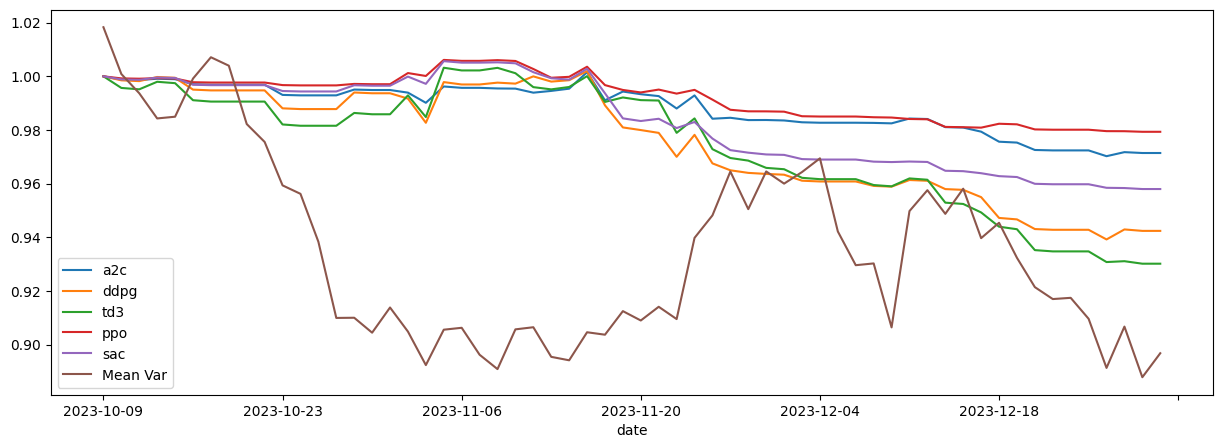

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()